## Analysis and Plots

#### Libraries

In [1]:
# This command will iterate through numbers 3 to 9 and remove corresponding files named
# "Fig2.jpg" through "Fig9.jpg" in the specified directory.

#! for i in $(seq 2 1 11); do rm /storage2/tkyeimiah/Plots/Fig$i.jpg; done#

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns

In [3]:
start_time=time.time()

path = '/storage2/tkyeimiah'


aice_dh = xr.open_dataset(path+'/iHESP/EM1/hist/aice_hist/aice_hist.nc')
aice_dp = xr.open_dataset(path+'/iHESP/EM1/proj/aice_proj/aice_proj.nc')


hi_dh = xr.open_dataset(path+'/iHESP/EM1/hist/hi_hist/hi_hist.nc')
hi_dp = xr.open_dataset(path+'/iHESP/EM1/proj/hi_proj/hi_proj.nc')


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.4907999038696289 seconds


In [4]:
def shift_month(ds):
    ds = ds.copy()  
    # Convert each cftime.DatetimeNoLeap to pandas datetime
    time_as_pd_datetime = [pd.Timestamp(date.year, date.month, date.day) for date in ds['time'].values]

    # Subtract one month
    time_as_pd_datetime = [date - pd.DateOffset(months=1) for date in time_as_pd_datetime]

    # Convert back to cftime.DatetimeNoLeap
    time_as_cftime = [cftime.DatetimeNoLeap(date.year, date.month, date.day) for date in time_as_pd_datetime]

    # Replace the time coordinate in the dataset
    ds['time'] = time_as_cftime
    
    return ds

### CESM-HR

In [5]:
aice_hist=shift_month(aice_dh['aice'])
aice_proj=shift_month(aice_dp['aice'])

tarea_hist=aice_dh['uarea']
tarea_proj=aice_dp['uarea']

In [6]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_hist = ((aice_hist.TLAT >= lat_min) & (aice_hist.TLAT <= lat_max) &
        (aice_hist.TLON >= lon_min) & (aice_hist.TLON <= lon_max))

mask_hist2 = ((tarea_hist.TLAT >= lat_min) & (tarea_hist.TLAT <= lat_max) &
        (tarea_hist.TLON >= lon_min) & (tarea_hist.TLON <= lon_max))

mask_proj = ((aice_proj.TLAT >= lat_min) & (aice_proj.TLAT <= lat_max) &
        (aice_proj.TLON >= lon_min) & (aice_proj.TLON <= lon_max))

mask_proj2 = ((tarea_proj.TLAT >= lat_min) & (tarea_proj.TLAT <= lat_max) &
        (tarea_proj.TLON >= lon_min) & (tarea_proj.TLON <= lon_max))

# Apply the mask to the aice variable
aice_hist_region_ =aice_hist.where(mask_hist, drop=True)
tarea_hist_region_=tarea_hist.where(mask_hist2, drop=True)
aice_proj_region_ =aice_proj.where(mask_proj, drop=True)
tarea_proj_region_=tarea_proj.where(mask_proj2, drop=True)

#### SIE

In [7]:
sic_greater_15hist = xr.where(aice_hist_region_ >= 15, 1, 0)
sic_greater_15proj = xr.where(aice_proj_region_ >= 15, 1, 0)

aice_hist_region = (sic_greater_15hist * tarea_hist_region_)/1e12
aice_proj_region = (sic_greater_15proj * tarea_proj_region_)/1e12

In [8]:
#plot for article
model_1990_99 = aice_hist_region.sel(time=slice('1990-01-01','1999-12-31'))
model_2000_05 = aice_hist_region.sel(time=slice('2000-01-01','2005-12-31'))
model_2006_20 = aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_2000_20 = xr.concat([model_2000_05, model_2006_20], dim='time')
model_2040_60 = aice_proj_region.sel(time=slice('2040-01-01','2060-12-31'))
model_2080_100= aice_proj_region.sel(time=slice('2080-01-01','2100-12-31'))

In [9]:
model_1990_99_monthly = model_1990_99.groupby('time.month').mean('time').sum(('nj','ni'))
model_2000_20_monthly = model_2000_20.groupby('time.month').mean('time').sum(('nj','ni'))

model_1990_99_monmax = model_1990_99.groupby('time.month').max('time').sum(('nj','ni'))
model_2000_20_monmax = model_2000_20.groupby('time.month').max('time').sum(('nj','ni'))

model_1990_99_monmin = model_1990_99.groupby('time.month').min('time').sum(('nj','ni'))
model_2000_20_monmin = model_2000_20.groupby('time.month').min('time').sum(('nj','ni'))

#### SIC

In [10]:
#plot for article
model_sic_1990_99 = aice_hist_region_.sel(time=slice('1990-01-01','1999-12-31'))
model_sic_2000_05 = aice_hist_region_.sel(time=slice('2000-01-01','2005-12-31'))
model_sic_2006_20 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_sic_2000_20 = xr.concat([model_sic_2000_05, model_sic_2006_20], dim='time')
model_sic_2040_60 = aice_proj_region_.sel(time=slice('2040-01-01','2060-12-31'))
model_sic_2080_100= aice_proj_region_.sel(time=slice('2080-01-01','2100-12-31'))

In [11]:
model_hist=aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
model_proj=aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_CT_sel= xr.concat([model_hist, model_proj], dim='time')

#### SIT

In [12]:
hi_hist=shift_month(hi_dh['hi'])
hi_proj=shift_month(hi_dp['hi'])

In [13]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hist3 = ((hi_hist.TLAT >= lat_min) & (hi_hist.TLAT <= lat_max) &
              (hi_hist.TLON >= lon_min) & (hi_hist.TLON <= lon_max))


mask_proj3 = ((hi_proj.TLAT >= lat_min) & (hi_proj.TLAT <= lat_max) &
              (hi_proj.TLON >= lon_min) & (hi_proj.TLON <= lon_max))

# Apply the mask to the aice variable
hi_hist_region=hi_hist.where(mask_hist3, drop=True)
hi_proj_region=hi_proj.where(mask_proj3, drop=True)

In [14]:
#plot for article
model_hi_1990_99 = hi_hist_region.sel(time=slice('1990-01-01','1999-12-31'))
model_hi_2000_05 = hi_hist_region.sel(time=slice('2000-01-01','2005-12-31'))
model_hi_2006_20 = hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2000_20 = xr.concat([model_hi_2000_05, model_hi_2006_20], dim='time')
model_hi_2040_60 = hi_proj_region.sel(time=slice('2040-01-01','2060-12-31'))
model_hi_2080_100= hi_proj_region.sel(time=slice('2080-01-01','2100-12-31'))

In [15]:
model_hi_1990_99_monthly = model_hi_1990_99.groupby('time.month').mean('time').mean(('nj','ni'))
model_hi_2000_20_monthly = model_hi_2000_20.groupby('time.month').mean('time').mean(('nj','ni'))

model_hi_1990_99_monmax = model_hi_1990_99.groupby('time.month').max('time').mean(('nj','ni'))
model_hi_2000_20_monmax = model_hi_2000_20.groupby('time.month').max('time').mean(('nj','ni'))

model_hi_1990_99_monmin = model_hi_1990_99.groupby('time.month').min('time').mean(('nj','ni'))
model_hi_2000_20_monmin = model_hi_2000_20.groupby('time.month').min('time').mean(('nj','ni'))

### CESM2-LE

In [16]:
start_time=time.time()

Cesm_lr=xr.open_dataset(path+'/CESM2-LE/aice/EM_1001.nc')

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.25966691970825195 seconds


In [17]:
aice_lr=shift_month(Cesm_lr['aice'])
tarea_lr=Cesm_lr['uarea']

In [18]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_lr = ((aice_lr.TLAT >= lat_min) & (aice_lr.TLAT <= lat_max) &
        (aice_lr.TLON >= lon_min) & (aice_lr.TLON <= lon_max))

mask_lr2 = ((tarea_lr.TLAT >= lat_min) & (tarea_lr.TLAT <= lat_max) &
        (tarea_lr.TLON >= lon_min) & (tarea_lr.TLON <= lon_max))

# Apply the mask to the aice variable
aice_lr_region_ =aice_lr.where(mask_lr, drop=True)
tarea_lr_region_=tarea_lr.where(mask_lr2, drop=True)

#### SIE

In [19]:
sic_greater_lr_15 = xr.where(aice_lr_region_ >= 0.15, 1, 0)
aice_lr_region = (sic_greater_lr_15 * tarea_lr_region_)/1e12

## CIS

In [20]:
start_time=time.time()

area=xr.open_dataset(path+'/Obs/CIS/CIS_year/area_all_combined.nc')
obs=xr.open_dataset(path+'/Obs/CIS/CIS_year/CT_all_combined.nc')
obs1=xr.open_dataset(path+'/Obs/CIS/CIS_year/CT_all_combined1.nc')
end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.16124916076660156 seconds


In [21]:
obs_CT=obs['CT']
obs_area=area['area']
CT1=obs1['CT']

In [22]:
CT1_resampled=CT1.resample(time='1M').mean('time', skipna=True)

In [23]:
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45 

# Create a mask for Labrador coast 
maskobs = ((obs_CT.lat>= lat_min) & (obs_CT.lat <= lat_max) & (obs_CT.lon >= lon_min) & (obs_CT.lon<= lon_max))
maskobs1 = ((obs_area.lat>= lat_min) & (obs_area.lat <= lat_max) & (obs_area.lon >= lon_min) & (obs_area.lon<= lon_max))
maskobs2 = ((CT1_resampled.lat>= lat_min) & (CT1_resampled.lat <= lat_max) & (CT1_resampled.lon >= lon_min) & (CT1_resampled.lon<= lon_max))
obs_CT_region_ =obs_CT.where(maskobs, drop=True)
obs_CT_region_1 =CT1_resampled.where(maskobs2, drop=True)
obs_area_region =obs_area.where(maskobs1, drop=True)

In [24]:
#function: interpolating feb and april to get march values
def interp1(data, start_year, end_year):
    for year in range(start_year, end_year+1):
        # Check if the year is a leap year using modulo
        is_leap = (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)
    
        feb_date = f"{year}-02-29" if is_leap else f"{year}-02-28"
        feb_data = data.sel(time=feb_date).squeeze()  # squeeze removes singular dimensions
    
        apr_data = data.sel(time=f"{year}-04-30").squeeze()  # squeeze removes singular dimensions

        # Using broadcasting to compute the average across all lat and lon points for the specific time.
        average_data = (feb_data + apr_data) / 2

        # Replace March data for all lat, lon combinations with computed average
        data.loc[dict(time=f"{year}-03-31")] = average_data
    return data

In [25]:
#applying function
#obs_CT_resampled=interp1(obs_CT_region_, 1990, 2020)
obs_CT_resampled1=interp1(obs_CT_region_1, 1990, 2020)
obs_area_resampled=interp1(obs_area_region, 1990, 2020) 

In [26]:
obs_CT_resampled=obs_CT_resampled1.fillna(0)
#obs_CT_resampled=obs_CT_region_1.fillna(0)

#### SIE

In [27]:
#replacing all ice 15 % and above with 1 and less with 0
obs_greater_15 = xr.where(obs_CT_resampled >= 0.15, 1, 0)

#calculating the SIE
obs_CT_region=(obs_greater_15 * obs_area_resampled)/1e6

In [28]:
#sel
cis_1990_99 = obs_CT_region.sel(time=slice('1990', '1999'))
cis_2000_20 = obs_CT_region.sel(time=slice('2000', '2020'))

In [29]:
cis_1990_99_monthly = cis_1990_99.groupby('time.month').mean('time').sum(['rlat','rlon'])
cis_2000_20_monthly = cis_2000_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

cis_1990_99_monmax = cis_1990_99.groupby('time.month').max('time').sum(['rlat','rlon'])
cis_2000_20_monmax = cis_2000_20.groupby('time.month').max('time').sum(['rlat','rlon'])

cis_1990_99_monmin = cis_1990_99.groupby('time.month').min('time').sum(['rlat','rlon'])
cis_2000_20_monmin = cis_2000_20.groupby('time.month').min('time').sum(['rlat','rlon'])

In [30]:
obs_1990_99 = obs_CT_region.sel(time=slice('1990', '1999'))
obs_2000_09 = obs_CT_region.sel(time=slice('2000', '2009'))
obs_2010_20 = obs_CT_region.sel(time=slice('2010', '2020'))

In [31]:
obs_1990_99_monthly = obs_1990_99.groupby('time.month').mean('time').sum(['rlat','rlon'])
obs_2000_09_monthly = obs_2000_09.groupby('time.month').mean('time').sum(['rlat','rlon'])
obs_2010_20_monthly = obs_2010_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

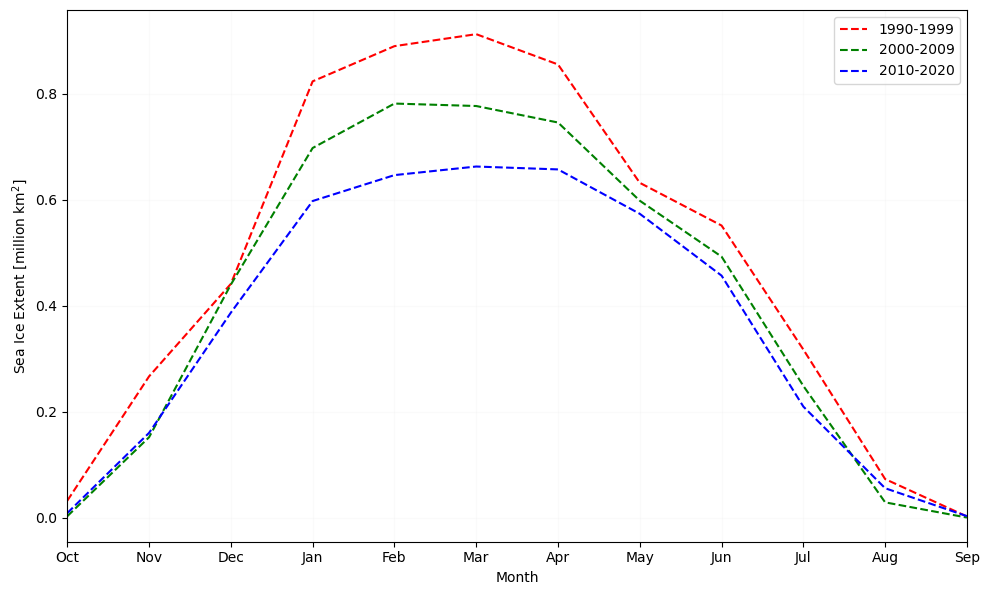

Execution time:  0.0 hours, 0.0 minutes, 0.9094460010528564 seconds


In [32]:
# Set xticks to represent months from January to December

start_time = time.time()

fig,ax=plt.subplots(figsize=(10,6.05))
#all_data = [ model_1990_99_monthly,model_2000_09_monthly, model_2010_19_monthly ]
all_data_a =[obs_1990_99_monthly, obs_2000_09_monthly ,obs_2010_20_monthly]
labels=['1990','2000','2010']


labels = ['1990-1999', '2000-2009', '2010-2020']

cmapp=['lime', 'darkgreen', 'salmon', 'cyan', 'magenta', 'yellow', 'coral', 'maroon', 
      'purple',  'navy', 'turquoise','beige', 'peachpuff', 'lightblue', 'red', 'green', 'blue',
      'gold', 'indigo', 'pink', 'olive','violet', 'brown', 'orange', 'black',]
colors=[cmapp[14], cmapp[15], cmapp[16]]

for i in range(len(all_data_a)):
    
    linestyle = '--'  # Default linestyle
    ax.plot(np.arange(12), np.append(all_data_a[i][9:],all_data_a[i][:9]), color=colors[i],  label=labels[i], linestyle=linestyle)
    

plt.xticks(np.arange(0,12), ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sep'])
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sea Ice Extent [million km$^2$]')
plt.grid(alpha=0.05)
plt.xlim(0,11)
plt.tight_layout()
#plt.savefig(path+'/plots/'+'plot1-new1.jpg', dpi=300, bbox_inches='tight')

plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

#### SIC

In [33]:
cis_sic_1990_99 = obs_CT_resampled.sel(time=slice('1990', '1999'))
cis_sic_2000_20 = obs_CT_resampled.sel(time=slice('2000', '2020'))

obs_CT_sel=obs_CT_resampled

In [34]:
obs_1990_99ct = obs_CT_resampled.sel(time=slice('1990', '1999'))
obs_2000_09ct = obs_CT_resampled.sel(time=slice('2000', '2009'))
obs_2010_20ct = obs_CT_resampled.sel(time=slice('2010', '2020'))

In [35]:
obs_1990_99_monthlyct = obs_1990_99ct.groupby('time.month').mean('time').mean(['rlat','rlon'])
obs_2000_09_monthlyct = obs_2000_09ct.groupby('time.month').mean('time').mean(['rlat','rlon'])
obs_2010_20_monthlyct = obs_2010_20ct.groupby('time.month').mean('time').mean(['rlat','rlon'])

### PLOT SECTION

### Fig 2

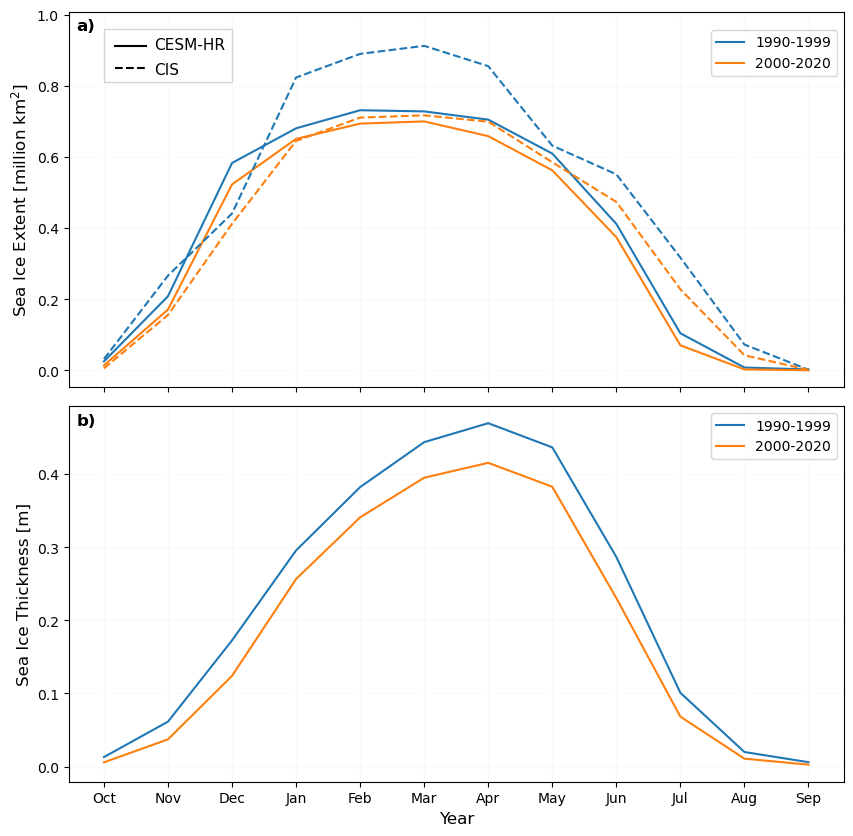

Execution time:  0.0 hours, 0.0 minutes, 1.232741355895996 seconds


In [36]:
###article

start_time = time.time()
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1990_99_monthly, model_2000_20_monthly, cis_1990_99_monthly, cis_2000_20_monthly]
mc_data_mx= [model_1990_99_monmax, model_2000_20_monmax, cis_1990_99_monmax, cis_2000_20_monmax]
mc_data_mn= [model_1990_99_monmin, model_2000_20_monmin, cis_1990_99_monmin, cis_2000_20_monmin]

hi_dt =[model_hi_1990_99_monthly, model_hi_2000_20_monthly]
hi_data_mx =[model_hi_1990_99_monmax, model_hi_2000_20_monmax]
hi_data_mn =[model_hi_1990_99_monmin, model_hi_2000_20_monmin]


cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1990-1999', '2000-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.0,0.97))
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
    ax[0].grid(alpha=0.05)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    ls='-'
    ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
    #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),
                       #color=cl[i], alpha=0.03)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=12)
    ax[1].set_xlabel('Year', fontsize=12)
    ax[1].grid(alpha=0.05)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='lightgray',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)

# Add CESM-HR text and line
ax[0].text(0.11, 0.9, 'CESM-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes, fontweight='bold', fontsize=12)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 3

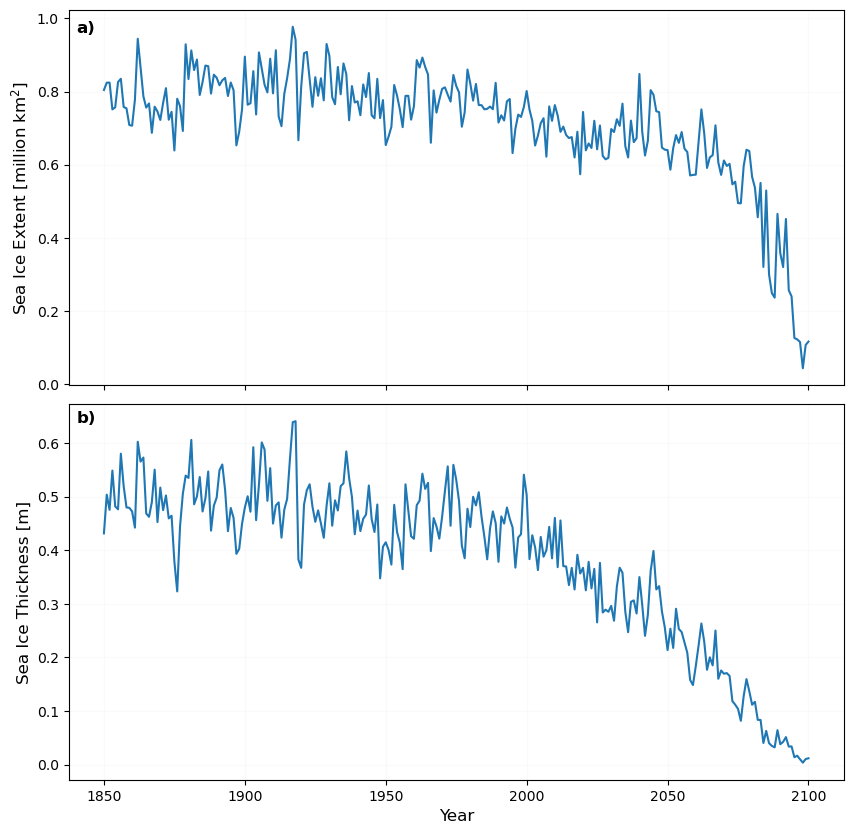

Execution time:  0.0 hours, 0.0 minutes, 1.1641762256622314 seconds


In [37]:
start_time = time.time()

march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

march_aice_lr = aice_lr_region.sel(time=slice('1850','2100'))[2::12].sum(('nj', 'ni'))

march_hi_hist = hi_hist_region.sel(time=slice('1850','2005'))[2::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region.sel(time=slice('2006','2100'))[2::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')



fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)

# First plot              
ax[0].plot(years, march_aice, label='CESM-HR')
#ax[0].plot(years, march_aice_lr, label='CESM-LR')
ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
#ax[0].legend(loc='upper right')
ax[0].grid(alpha=0.05)
                 
# Second plot         
ax[1].plot(years, march_hi, label='CESM-HR')
ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=12)
ax[1].grid(alpha=0.05)
#ax[1].legend(loc='upper right')
ax[1].set_xlabel('Year', fontsize=12)

ax[0].text(0.01, 0.94, 'a)',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes, fontweight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig3.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


### Fig 4

In [38]:
model_sic_1990_99_=model_sic_1990_99[2::12].mean('time')
model_sic_2000_20_=model_sic_2000_20[2::12].mean('time')
model_sic_2040_60_=model_sic_2040_60[2::12].mean('time')
model_sic_2080_100_=model_sic_2080_100[2::12].mean('time')
cis_sic_1990_99_=cis_sic_1990_99[2::12].mean('time')*100
cis_sic_2000_20_=cis_sic_2000_20[2::12].mean('time')*100

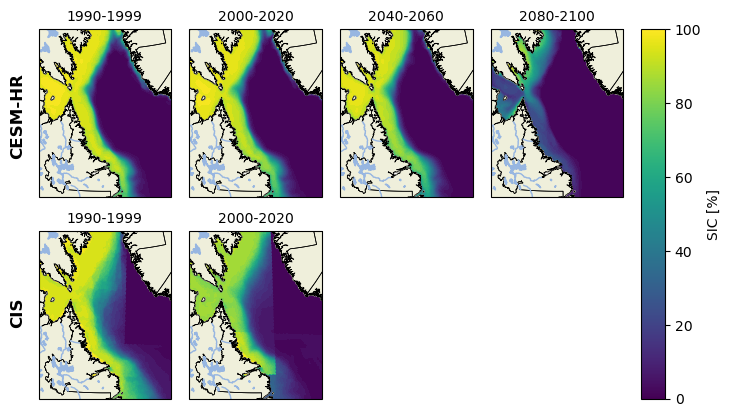

Execution time:  0.0 hours, 0.0 minutes, 31.595128774642944 seconds


In [39]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))
sic_data = [model_sic_1990_99_, model_sic_2000_20_, model_sic_2040_60_, model_sic_2080_100_,
                 cis_sic_1990_99_, cis_sic_2000_20_]

#hi_data1 = [model_hi_1990_99, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1990-1999', '2000-2020', '2040-2060', '2080-2100', '1990-1999', '2000-2020']


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    if i in [0,1,2,3]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],
                          levels=45, norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    if i in [4,5]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],
                          levels=45, norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)  

name=['CESM-HR','CIS']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig4.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 5

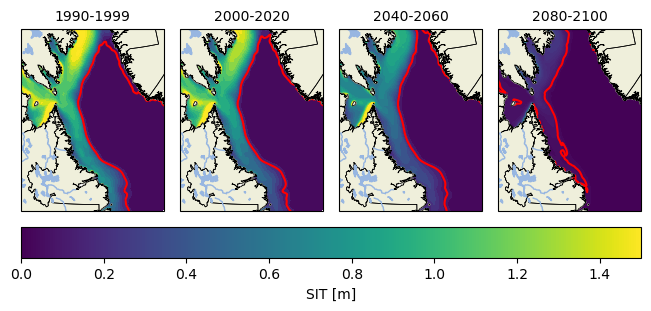

Execution time:  0.0 hours, 0.0 minutes, 39.102514028549194 seconds


In [40]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,2.4))
sic_data = [model_sic_1990_99_, model_sic_2000_20_, model_sic_2040_60_, model_sic_2080_100_]

hi_data1 = [model_hi_1990_99, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1990-1999', '2000-2020', '2040-2060', '2080-2100',]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][2::12].mean('time'),levels=45,
                norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    #if i in [4,5]:
        #contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],
                          #levels=45, norm=norm, transform=ccrs.PlateCarree())
    
    
cbar_ax = fig.add_axes([0.125, -0.08, 0.775, 0.13])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='horizontal', label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=10)  


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig5.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 6

In [41]:
hi_month_1990_2005=hi_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
hi_month_2006_2020=hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
hi_region_1990_2020=xr.concat((hi_month_1990_2005,hi_month_2006_2020 ), dim='time')
hi_months=hi_region_1990_2020.groupby('time.month').mean('time')

In [42]:
#plot for article
sic_month_1990_2005 = aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
sic_month_2006_2020 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
sic_region_1990_2020= xr.concat([sic_month_1990_2005, sic_month_2006_2020], dim='time')
sic_months=sic_region_1990_2020.groupby('time.month').mean('time')

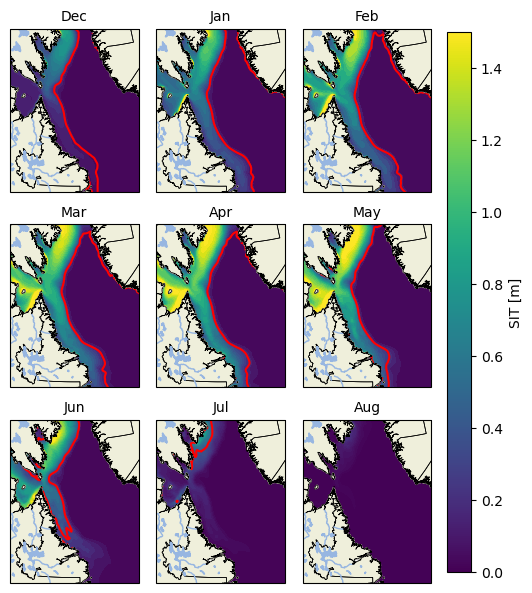

In [43]:
fig = plt.figure(figsize=(6, 7.2))

selected_data= [hi_months[11], hi_months[0], hi_months[1], hi_months[2], hi_months[3], hi_months[4], hi_months[5], hi_months[6],hi_months[7]]
selected_data1=[sic_months[11],sic_months[0],sic_months[1],sic_months[2],sic_months[3], sic_months[4], sic_months[5],sic_months[6],sic_months[7]]


titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
#name=['a)','b)','c)','d)','e)','f)','g)','h)','i)']

global_min = np.min([np.nanmin(data.values) for data in selected_data])
global_max = np.max([np.nanmax(data.values) for data in selected_data])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67


# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
    ax = plt.subplot(3,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    #ax.add_feature(cfeature.BORDERS,  zorder=2)
    
    
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,name[i], transform=ax.transAxes, fontsize=10)
    ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i], levels=45, norm=norm,
                   transform=ccrs.PlateCarree(), )
    ax.contour(selected_data1[i].TLON, selected_data1[i].TLAT, selected_data1[i], levels=[15], norm=norm, colors='red',
               linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
cbar_ax = fig.add_axes([0.89, 0.125, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=10)  

plt.subplots_adjust(wspace=-0.15)
plt.savefig('/storage2/tkyeimiah/Plots/Fig6.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 7

In [44]:
model_SIE_hist =aice_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
model_SIE_proj =aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_SIE= xr.concat([model_SIE_hist, model_SIE_proj], dim='time')

obs_SIE=obs_CT_region

model_SIE_march=model_SIE[2::12].sum(('nj', 'ni'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])
model_SIE_march_lr = aice_lr_region.sel(time=slice('1990-01-01','2020-12-31'))[2::12].sum(('nj', 'ni'))

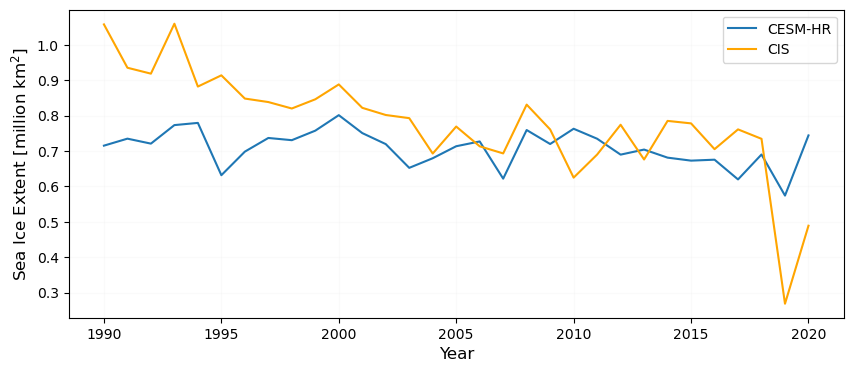

Execution time:  0.0 hours, 0.0 minutes, 0.5535268783569336 seconds


In [45]:
#Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, label='CESM-HR', color='tab:blue', )
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
ax.legend()
ax.grid(alpha=0.05)
#plt.xlim(1990,2019)

plt.savefig('/storage2/tkyeimiah/Plots/Fig7.jpg',dpi=500, bbox_inches='tight') 
plt.show()


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

In [46]:
def rmse(predictions, targets):
    differences = predictions - targets                       # the differences between prediction and observation
    differences_squared = differences ** 2                    # square the differences
    mean_of_differences_squared = differences_squared.mean()  # mean of the squared differences
    rmse_val = np.sqrt(mean_of_differences_squared)           # square root of the mean of the squared differences
    return rmse_val

In [47]:
HR_rmse=rmse(model_SIE_march.values,obs_SIE_march.values)
LR_rmse=rmse(model_SIE_march_lr.values,obs_SIE_march.values)
print(HR_rmse,LR_rmse)

0.15079645622603577 0.19714975911166382


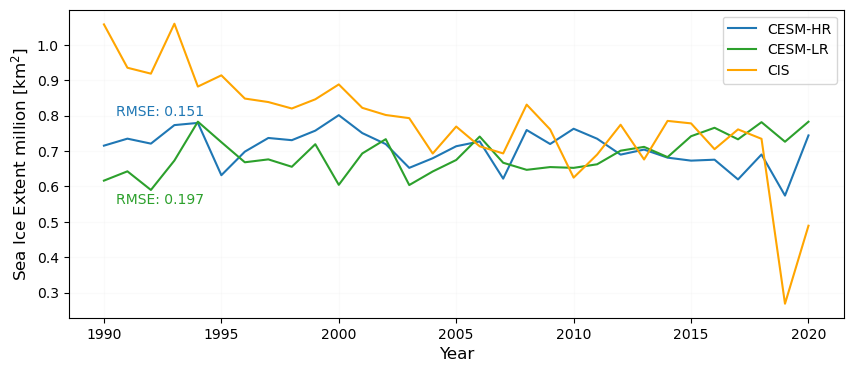

Execution time:  0.0 hours, 0.0 minutes, 0.35369014739990234 seconds


In [48]:
#Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, color='tab:blue', label='CESM-HR')
ax.plot(np.arange(1990,2021), model_SIE_march_lr,color='tab:green', label='CESM-LR')
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Sea Ice Extent million [km$^2$]', fontsize=12)
ax.legend()

# Add RMSE to the plot
ax.text(1990.5, 0.8, f'RMSE: {HR_rmse:.3f}', color='tab:blue', fontsize=10)  # Adjust position and values as needed
ax.text(1990.5, 0.55, f'RMSE: {LR_rmse:.3f}', color='tab:green', fontsize=10)  # Adjust position and values as needed

ax.grid(alpha=0.05)

plt.savefig('/storage2/tkyeimiah/Plots/Fig11.jpg',dpi=300, bbox_inches='tight') 
plt.show()

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 8

In [49]:
#----------
obs_CT_1990_99 = obs_CT_sel.sel(time=slice('1990', '1999'))
obs_CT_2000_09 = obs_CT_sel.sel(time=slice('2000', '2009'))
obs_CT_2010_20 = obs_CT_sel.sel(time=slice('2010', '2020'))

#----------
model_CT_1990_99 = model_CT_sel.sel(time=slice('1990', '1999'))
model_CT_2000_09 = model_CT_sel.sel(time=slice('2000', '2009'))
model_CT_2010_20 = model_CT_sel.sel(time=slice('2010', '2020'))

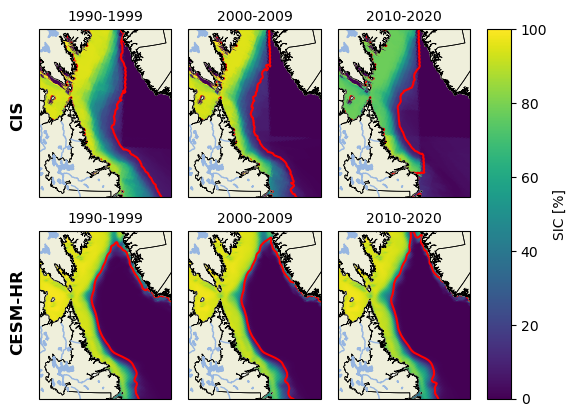

Execution time:  0.0 hours, 0.0 minutes, 23.58512306213379 seconds


In [50]:
start_time = time.time()

# Create a figure with two# Create a figure with two subplots
fig = plt.figure(figsize=(6,4.8))

selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_20, model_CT_1990_99, model_CT_2000_09,model_CT_2010_20]
titles=['1990-1999', '2000-2009','2010-2020','1990-1999', '2000-2009','2010-2020']
#letter=['a)','b)','c)','d)','e)','f)']
norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1,2]:
        ax.scatter(selected_data[i].lon, selected_data[i].lat, c=selected_data[i][2::12].mean('time')*100,
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(selected_data[i].lon, selected_data[i].lat, selected_data[i][2::12].mean('time')*100, 
                   levels=[15], norm=norm, colors='red', linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
    if i in [3,4,5]:
        ax.scatter(selected_data[i].TLON, selected_data[i].TLAT, c=selected_data[i][2::12].mean('time'),
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i][2::12].mean('time'), 
                   levels=[15], norm=norm, colors='red',linewidth=5, transform=ccrs.PlateCarree(), zorder=1)

    
cbar_ax = fig.add_axes([0.9, 0.11, 0.04, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC (%)')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)  

name=['CIS', 'CESM-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig8.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 9

In [51]:
obs_months=obs_CT_sel.groupby('time.month').mean('time')
model_months=model_CT_sel.groupby('time.month').mean('time')

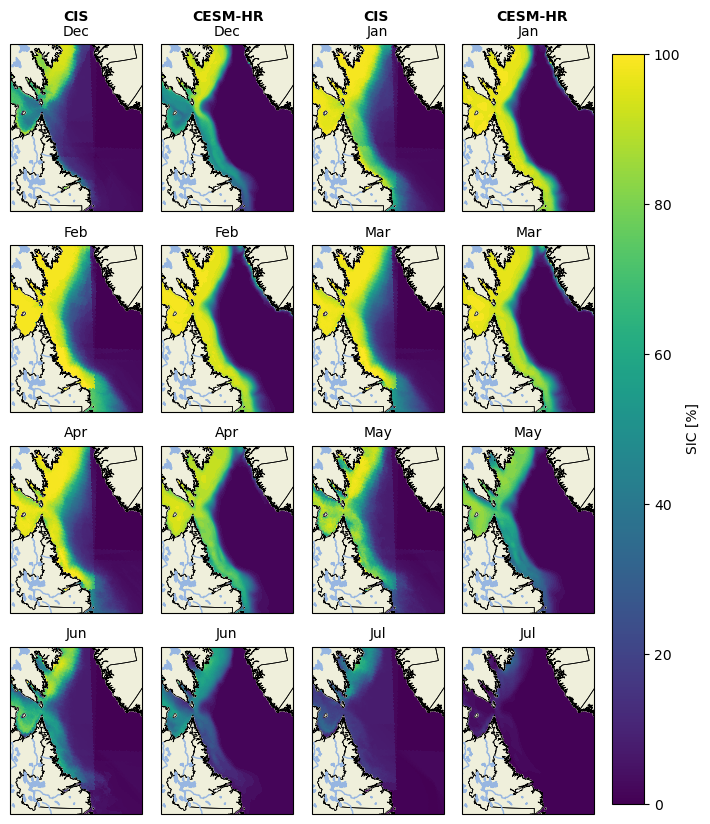

Execution time:  0.0 hours, 0.0 minutes, 20.6800274848938 seconds


In [52]:
start_time = time.time()
#fig = plt.figure(figsize=(8, 4.8))
fig = plt.figure(figsize=(8,10))
obs_data=[obs_months[-1], obs_months[0],obs_months[1],obs_months[2],obs_months[3],obs_months[4],
          obs_months[5],obs_months[6]]

model_data=[model_months[-1],model_months[0],model_months[1],model_months[2],model_months[3],model_months[4],
            model_months[5],model_months[6]]

titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=10)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.pcolormesh(obs_data[index].lon, obs_data[index].lat, obs_data[index]*100, vmax=90,
                    transform=ccrs.PlateCarree())
        #ax.text(0,1.05,name[index], transform=ax.transAxes, fontsize=10)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            ax.set_title(titles[index], fontsize=10)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=45,
                        norm=norm, transform=ccrs.PlateCarree(), zorder=1)
            #ax.text(0,1.05,name1[index], transform=ax.transAxes, fontsize=10)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)

name=['CIS', 'CESM-HR','CIS', 'CESM-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.9,0.9,0.9,0.9]
for i in range (4):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=10)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig9.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

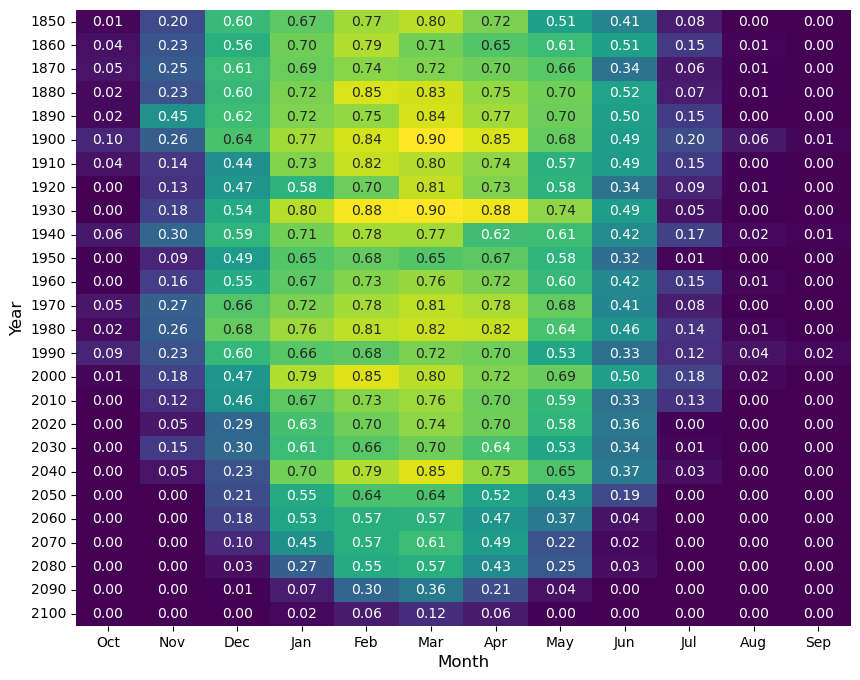

In [53]:
# Convert this DataArray to a DataFrame
aice1 = aice_hist_region.sel(time=slice('1850-01-01','2005-12-31'))
aice2 = aice_proj_region.sel(time=slice('2006-01-01','2100-12-31'))
aice3 = xr.concat([aice1, aice2], dim='time') 

ds_mean = aice3.sum(dim=['nj', 'ni'], skipna=True)
df = ds_mean.to_dataframe(name='SIE')

# Reset the index so that 'time' becomes a column
df.reset_index(inplace=True)

# Extract the year and month from the 'time' column
df['Year'] = [date.year for date in df['time']]
df['Month'] = [date.month for date in df['time']]

# Map numeric month to month name
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
              6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
              11: 'Nov', 12: 'Dec'}

df['Month'] = df['Month'].map(month_dict)

# Define custom sorting order for the months
custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Convert 'month' to categorical data type with custom order
df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

# Filter rows for the specified years
selected_years = np.arange(1850,2101,10)
df_all = df[df['Year'].isin(selected_years)]

# Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
pivot_df = df_all.pivot('Year', 'Month', 'SIE')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df,  cmap="viridis", annot=True, fmt='.2f', cbar=False)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
#cbar_kws={'label':'SIE [million km$^2$]'}
plt.savefig('/storage2/tkyeimiah/Plots/Fig10.jpg',dpi=500, bbox_inches='tight')
plt.show()

## LandFast Ice Analysis

#### CESM-HR

In [54]:
start_time=time.time()

path = '/storage2/tkyeimiah'


uvel_dh = xr.open_dataset(path+'/iHESP/EM1/hist/uvel_hist/uvel_hist.nc')
uvel_dp = xr.open_dataset(path+'/iHESP/EM1/proj/uvel_proj/uvel_proj.nc')


vvel_dh = xr.open_dataset(path+'/iHESP/EM1/hist/vvel_hist/vvel_hist.nc')
vvel_dp = xr.open_dataset(path+'/iHESP/EM1/proj/vvel_proj/vvel_proj.nc')


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.4078671932220459 seconds


#### Ice velocities

In [55]:
uvel_hist=shift_month(uvel_dh['uvel'])
uvel_proj=shift_month(uvel_dp['uvel'])

vvel_hist=shift_month(vvel_dh['vvel'])
vvel_proj=shift_month(vvel_dp['vvel'])

In [56]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_uvel_hist = ((uvel_hist.TLAT >= lat_min) & (uvel_hist.TLAT <= lat_max) &
        (uvel_hist.TLON >= lon_min) & (uvel_hist.TLON <= lon_max))

mask_uvel_proj = ((uvel_proj.TLAT >= lat_min) & (uvel_proj.TLAT <= lat_max) &
        (uvel_proj.TLON >= lon_min) & (uvel_proj.TLON <= lon_max))

mask_vvel_hist = ((vvel_hist.TLAT >= lat_min) & (vvel_hist.TLAT <= lat_max) &
        (vvel_hist.TLON >= lon_min) & (vvel_hist.TLON <= lon_max))

mask_vvel_proj = ((vvel_proj.TLAT >= lat_min) & (vvel_proj.TLAT <= lat_max) &
        (vvel_proj.TLON >= lon_min) & (vvel_proj.TLON <= lon_max))

# Apply the mask to the aice variable
uvel_hist_region_ =uvel_hist.where(mask_uvel_hist , drop=True)
uvel_proj_region_ =uvel_proj.where(mask_uvel_proj, drop=True)
vvel_hist_region_ =vvel_hist.where(mask_vvel_hist, drop=True)
vvel_proj_region_ =vvel_proj.where(mask_vvel_proj, drop=True)

#### Landfast ice 

In [57]:
# Function for landfast ice
def landfast_ice(uvel,vvel,conc,threshold):
    # Calculate the magnitude of the velocity
    velocity_magnitude = np.sqrt(uvel**2 + vvel**2)

    # Define a threshold for landfast ice 
    velocity_threshold = threshold  # 5*10^-4m/s == 0.05cm/s /// 4cm/s

    # Define a threshold for sea ice concentration to ensure ice presence
    concentration_threshold = 90 # 90%

    # Create a mask for where the velocity magnitude is less than the threshold
    landfast_mask = (velocity_magnitude < velocity_threshold) &  (conc >= concentration_threshold)
    
    # Apply the mask to the sea ice concentration
    landfast_ice_concentration = conc.where(landfast_mask)
    
    return landfast_ice_concentration

In [58]:
#0.5cm
model_fast_ice_hist_05_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 0.5)
model_fast_ice_proj_05_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 0.5)
model_fast_ice_hist_05 = (model_fast_ice_hist_05_ * tarea_hist_region_).sum(['nj','ni'])/1e12
model_fast_ice_proj_05 = (model_fast_ice_proj_05_ * tarea_proj_region_).sum(['nj','ni'])/1e12
model_fast_ice_05_1990_99 = model_fast_ice_hist_05.sel(time=slice('1990-01-01','1999-12-31'))
model_fast_ice_05_2000_05 = model_fast_ice_hist_05.sel(time=slice('2000-01-01','2005-12-31'))
model_fast_ice_05_2006_20 = model_fast_ice_proj_05.sel(time=slice('2006-01-01','2020-12-31'))
model_fast_ice_05_2000_20 = xr.concat([model_fast_ice_05_2000_05, model_fast_ice_05_2006_20], dim='time')
model_fast_ice_05_2040_60 = model_fast_ice_proj_05.sel(time=slice('2040-01-01','2060-12-31'))
model_fast_ice_05_2080_100 =model_fast_ice_proj_05.sel(time=slice('2080-01-01','2100-12-31'))

In [59]:
#2.5cm
model_fast_ice_hist_25_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 2.5)
model_fast_ice_proj_25_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 2.5)
model_fast_ice_hist_25 = (model_fast_ice_hist_25_ * tarea_hist_region_).sum(['nj','ni'])/1e12
model_fast_ice_proj_25 = (model_fast_ice_proj_25_ * tarea_proj_region_).sum(['nj','ni'])/1e12
model_fast_ice_25_1990_99 = model_fast_ice_hist_25.sel(time=slice('1990-01-01','1999-12-31'))
model_fast_ice_25_2000_05 = model_fast_ice_hist_25.sel(time=slice('2000-01-01','2005-12-31'))
model_fast_ice_25_2006_20 = model_fast_ice_proj_25.sel(time=slice('2006-01-01','2020-12-31'))
model_fast_ice_25_2000_20 = xr.concat([model_fast_ice_25_2000_05, model_fast_ice_25_2006_20], dim='time')
model_fast_ice_25_2040_60 = model_fast_ice_proj_25.sel(time=slice('2040-01-01','2060-12-31'))
model_fast_ice_25_2080_100 =model_fast_ice_proj_25.sel(time=slice('2080-01-01','2100-12-31'))

In [60]:
#5cm
model_fast_ice_hist_50_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 5)
model_fast_ice_proj_50_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 5)
model_fast_ice_hist_50 = (model_fast_ice_hist_50_ * tarea_hist_region_).sum(['nj','ni'])/1e12
model_fast_ice_proj_50 = (model_fast_ice_proj_50_ * tarea_proj_region_).sum(['nj','ni'])/1e12
model_fast_ice_50_1990_99 = model_fast_ice_hist_50.sel(time=slice('1990-01-01','1999-12-31'))
model_fast_ice_50_2000_05 = model_fast_ice_hist_50.sel(time=slice('2000-01-01','2005-12-31'))
model_fast_ice_50_2006_20 = model_fast_ice_proj_50.sel(time=slice('2006-01-01','2020-12-31'))
model_fast_ice_50_2000_20 = xr.concat([model_fast_ice_50_2000_05, model_fast_ice_50_2006_20], dim='time')
model_fast_ice_50_2040_60 = model_fast_ice_proj_50.sel(time=slice('2040-01-01','2060-12-31'))
model_fast_ice_50_2080_100 =model_fast_ice_proj_50.sel(time=slice('2080-01-01','2100-12-31'))

In [61]:
#7.5cm
model_fast_ice_hist_75_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 7.5)
model_fast_ice_proj_75_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 7.5)
model_fast_ice_hist_75 = (model_fast_ice_hist_75_ * tarea_hist_region_).sum(['nj','ni'])/1e12
model_fast_ice_proj_75 = (model_fast_ice_proj_75_ * tarea_proj_region_).sum(['nj','ni'])/1e12
model_fast_ice_75_1990_99 = model_fast_ice_hist_75.sel(time=slice('1990-01-01','1999-12-31'))
model_fast_ice_75_2000_05 = model_fast_ice_hist_75.sel(time=slice('2000-01-01','2005-12-31'))
model_fast_ice_75_2006_20 = model_fast_ice_proj_75.sel(time=slice('2006-01-01','2020-12-31'))
model_fast_ice_75_2000_20 = xr.concat([model_fast_ice_75_2000_05, model_fast_ice_75_2006_20], dim='time')
model_fast_ice_75_2040_60 = model_fast_ice_proj_75.sel(time=slice('2040-01-01','2060-12-31'))
model_fast_ice_75_2080_100 =model_fast_ice_proj_75.sel(time=slice('2080-01-01','2100-12-31'))

In [62]:
#10cm
model_fast_ice_hist_100_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 10)
model_fast_ice_proj_100_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 10)
model_fast_ice_hist_100 = (model_fast_ice_hist_100_ * tarea_hist_region_).sum(['nj','ni'])/1e12
model_fast_ice_proj_100 = (model_fast_ice_proj_100_ * tarea_proj_region_).sum(['nj','ni'])/1e12
model_fast_ice_100_1990_99 = model_fast_ice_hist_100.sel(time=slice('1990-01-01','1999-12-31'))
model_fast_ice_100_2000_05 = model_fast_ice_hist_100.sel(time=slice('2000-01-01','2005-12-31'))
model_fast_ice_100_2006_20 = model_fast_ice_proj_100.sel(time=slice('2006-01-01','2020-12-31'))
model_fast_ice_100_2000_20 = xr.concat([model_fast_ice_100_2000_05, model_fast_ice_100_2006_20], dim='time')
model_fast_ice_100_2040_60 = model_fast_ice_proj_100.sel(time=slice('2040-01-01','2060-12-31'))
model_fast_ice_100_2080_100 =model_fast_ice_proj_100.sel(time=slice('2080-01-01','2100-12-31'))

#### CIS Fast ice

In [63]:
start_time=time.time()
FA_data=xr.open_dataset(path+'/Obs/CIS/CIS_year/FA_all_combined.nc')
end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.07480788230895996 seconds


In [64]:
#selecting FA variable
FA=FA_data['FA']

In [65]:
# Create the fast ice mask
fast_ice_mask = FA == 8  # Fast ice code is 8

# Apply the fast ice mask to the SIC variable
obs_FA = CT1.where(fast_ice_mask)

In [66]:
obs_FA_resampled=obs_FA.resample(time='1M').mean('time', skipna=True)

In [67]:
# Create a mask for Labrador coast 
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45
mask_lab = ((obs_FA_resampled.lat>= lat_min) & (obs_FA_resampled.lat <= lat_max) &
            (obs_FA_resampled.lon >= lon_min) & (obs_FA_resampled.lon<= lon_max))
obs_fast_ice_lab =obs_FA_resampled.where(mask_lab, drop=True)

In [68]:
#calculation
obs_fast_ice_=(obs_fast_ice_lab * obs_area_resampled).sum(['rlat','rlon'])/1e6

In [69]:
obs_fast_ice= interp1(obs_fast_ice_, 1990, 2020 )

In [70]:
obs_fast_ice_1990_99 = obs_fast_ice.sel(time=slice('1990-01-01','1999-12-31'))
obs_fast_ice_2000_20 = obs_fast_ice.sel(time=slice('2000-01-01','2020-12-31'))

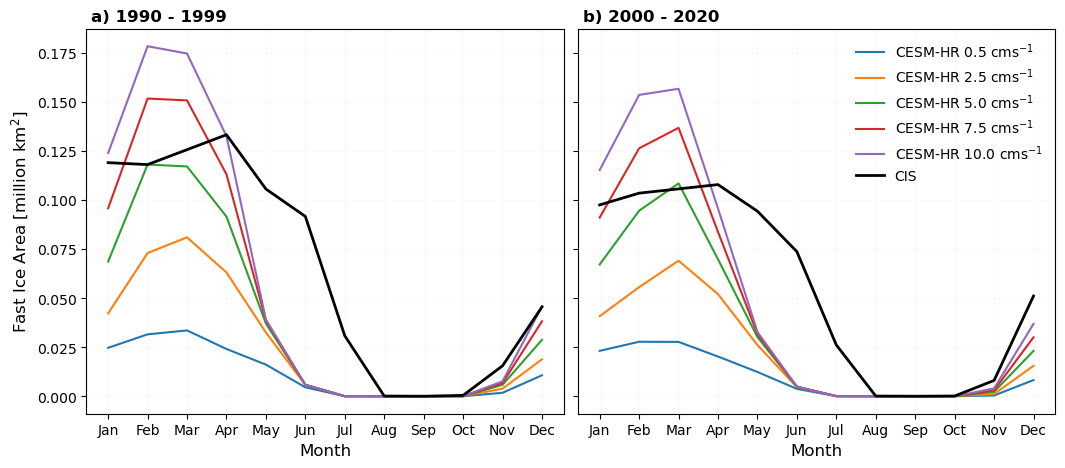

In [71]:
##plot
fig,ax=plt.subplots(1,2 , figsize=(12.5,5), sharex=True, sharey=True)
mt_label=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep','Oct','Nov','Dec']
ax[0].plot(mt_label,model_fast_ice_05_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[0].plot(mt_label,model_fast_ice_25_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[0].plot(mt_label,model_fast_ice_50_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[0].plot(mt_label,model_fast_ice_75_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[0].plot(mt_label,model_fast_ice_100_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[0].plot(mt_label,obs_fast_ice_1990_99.groupby('time.month').mean('time'), color='black', linewidth=2,
          label='CIS')
ax[0].grid(alpha=0.05)
ax[0].set_xlabel('Month', fontsize=12)
ax[0].set_ylabel('Fast Ice Area [million km$^2$]', fontsize=12)
ax[0].text(0.01, 1.02, 'a) 1990 - 1999',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
#ax[0].legend(frameon=False)

ax[1].plot(mt_label,model_fast_ice_05_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[1].plot(mt_label,model_fast_ice_25_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[1].plot(mt_label,model_fast_ice_50_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[1].plot(mt_label,model_fast_ice_75_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[1].plot(mt_label,model_fast_ice_100_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[1].plot(mt_label,obs_fast_ice_2000_20.groupby('time.month').mean('time'), color='black', linewidth=2,
           label='CIS')
ax[1].grid(alpha=0.05)
ax[1].set_xlabel('Month', fontsize=12)
ax[1].text(0.01, 1.02, 'b) 2000 - 2020',transform=ax[1].transAxes, fontweight='bold', fontsize=12)
ax[1].legend(frameon=False)

plt.subplots_adjust(wspace=0.03)

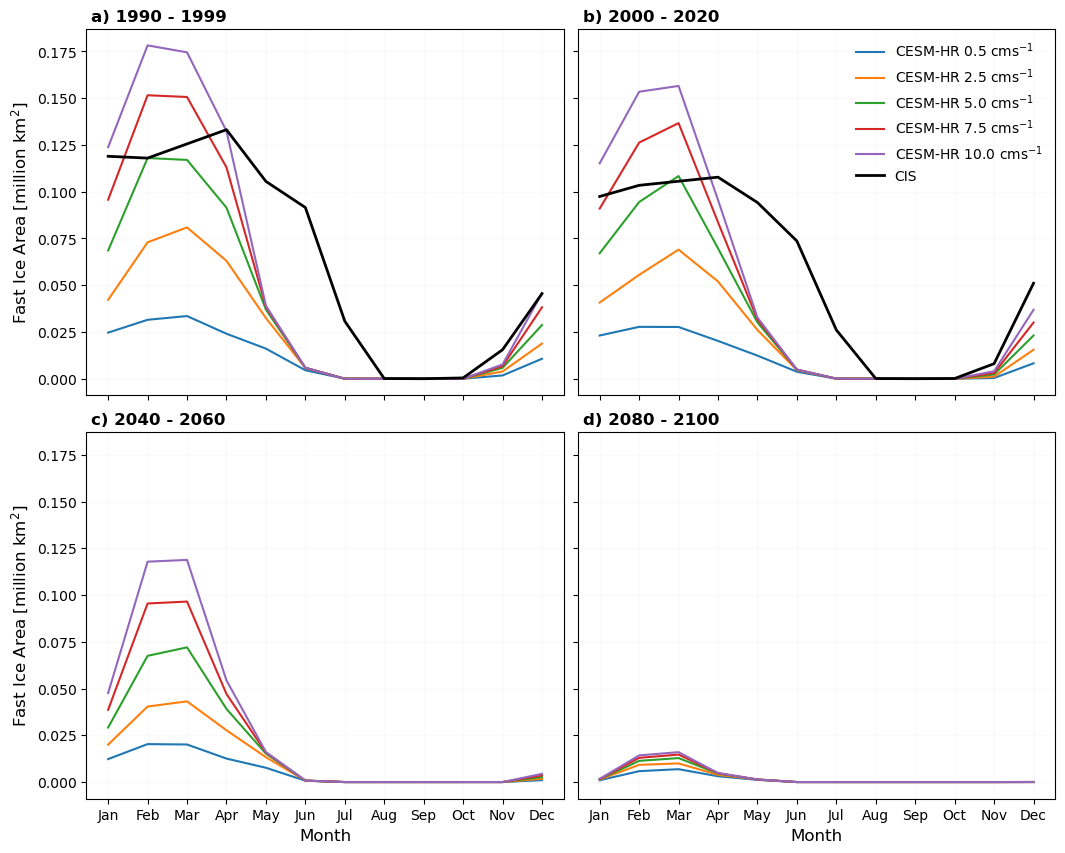

In [72]:
##plot
fig,ax=plt.subplots(2,2 , figsize=(12.5,10), sharex=True, sharey=True)
mt_label=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep','Oct','Nov','Dec']
ax[0,0].plot(mt_label,model_fast_ice_05_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[0,0].plot(mt_label,model_fast_ice_25_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[0,0].plot(mt_label,model_fast_ice_50_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[0,0].plot(mt_label,model_fast_ice_75_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[0,0].plot(mt_label,model_fast_ice_100_1990_99.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[0,0].plot(mt_label,obs_fast_ice_1990_99.groupby('time.month').mean('time'), color='black', linewidth=2,
          label='CIS')
ax[0,0].grid(alpha=0.05)
ax[0,0].set_ylabel('Fast Ice Area [million km$^2$]', fontsize=12)
ax[0,0].text(0.01, 1.02, 'a) 1990 - 1999',transform=ax[0,0].transAxes, fontweight='bold', fontsize=12)


ax[0,1].plot(mt_label,model_fast_ice_05_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[0,1].plot(mt_label,model_fast_ice_25_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[0,1].plot(mt_label,model_fast_ice_50_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[0,1].plot(mt_label,model_fast_ice_75_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[0,1].plot(mt_label,model_fast_ice_100_2000_20.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[0,1].plot(mt_label,obs_fast_ice_2000_20.groupby('time.month').mean('time'), color='black', linewidth=2,
           label='CIS')
ax[0,1].grid(alpha=0.05)
ax[0,1].text(0.01, 1.02, 'b) 2000 - 2020',transform=ax[0,1].transAxes, fontweight='bold', fontsize=12)
ax[0,1].legend(frameon=False)


ax[1,0].plot(mt_label,model_fast_ice_05_2040_60.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[1,0].plot(mt_label,model_fast_ice_25_2040_60.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[1,0].plot(mt_label,model_fast_ice_50_2040_60.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[1,0].plot(mt_label,model_fast_ice_75_2040_60.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[1,0].plot(mt_label,model_fast_ice_100_2040_60.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[1,0].grid(alpha=0.05)
ax[1,0].set_xlabel('Month', fontsize=12)
ax[1,0].set_ylabel('Fast Ice Area [million km$^2$]', fontsize=12)
ax[1,0].text(0.01, 1.02, 'c) 2040 - 2060',transform=ax[1,0].transAxes, fontweight='bold', fontsize=12)


ax[1,1].plot(mt_label,model_fast_ice_05_2080_100.groupby('time.month').mean('time')/100, label='CESM-HR 0.5 cms$^{-1}$')
ax[1,1].plot(mt_label,model_fast_ice_25_2080_100.groupby('time.month').mean('time')/100, label='CESM-HR 2.5 cms$^{-1}$')
ax[1,1].plot(mt_label,model_fast_ice_50_2080_100.groupby('time.month').mean('time')/100, label='CESM-HR 5.0 cms$^{-1}$')
ax[1,1].plot(mt_label,model_fast_ice_75_2080_100.groupby('time.month').mean('time')/100, label='CESM-HR 7.5 cms$^{-1}$')
ax[1,1].plot(mt_label,model_fast_ice_100_2080_100.groupby('time.month').mean('time')/100, label='CESM-HR 10.0 cms$^{-1}$')
ax[1,1].grid(alpha=0.05)
ax[1,1].set_xlabel('Month', fontsize=12)
ax[1,1].text(0.01, 1.02, 'd) 2080 - 2100',transform=ax[1,1].transAxes, fontweight='bold', fontsize=12)
plt.subplots_adjust(wspace=0.03, hspace=0.1)

plt.savefig('/storage2/tkyeimiah/Plots/Fig12.jpg',dpi=500, bbox_inches='tight')
plt.show()


In [73]:
##pcolormesh
#--------------------
fast_ice_05_1990_99_ = model_fast_ice_hist_05_.sel(time=slice('1990-01-01','1999-12-31'))
fast_ice_50_1990_99_ = model_fast_ice_hist_50_.sel(time=slice('1990-01-01','1999-12-31'))
fast_ice_cis_1990_99_= interp1(obs_fast_ice_lab, 1990, 1999 ).sel(time=slice('1990-01-01','1999-12-31'))

In [74]:
##pcolormesh
#--------------------
fast_ice_05_2000_20_ = model_fast_ice_hist_05_.sel(time=slice('2000-01-01','2020-12-31'))
fast_ice_50_2000_20_ = model_fast_ice_hist_50_.sel(time=slice('2000-01-01','2020-12-31'))
fast_ice_cis_2000_20_= interp1(obs_fast_ice_lab, 2000, 2020 ).sel(time=slice('2000-01-01','2020-12-31'))

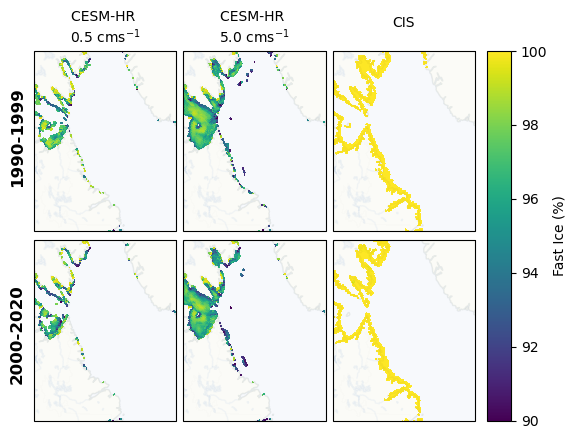

Execution time:  0.0 hours, 0.0 minutes, 10.052252531051636 seconds


In [76]:
start_time = time.time()

# Create a figure with two# Create a figure with two subplots
fig = plt.figure(figsize=(6,4.8))

selected_data=[fast_ice_05_1990_99_,fast_ice_50_1990_99_,fast_ice_cis_1990_99_,
               fast_ice_05_2000_20_,fast_ice_50_2000_20_,fast_ice_cis_2000_20_]

titles=title=['CESM-HR \n0.5 cms$^{-1}$', 'CESM-HR \n5.0 cms$^{-1}$', 'CIS\n']
#letter=['a)','b)','c)','d)','e)','f)']
norm = plt.Normalize(90, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.coastlines(alpha=0.03, zorder=11)
    ax.add_feature(cfeature.LAND, alpha=0.2)
    ax.add_feature(cfeature.OCEAN, alpha=0.075)
    ax.add_feature(cfeature.STATES, alpha=0.003)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  alpha=0.1, zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  alpha=0.1, zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    
    if i in [2,5]:
        ax.pcolormesh(selected_data[i].lon, selected_data[i].lat, selected_data[i][2::12].mean('time')*100,
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    if i in [0,1,3,4]:
        ax.pcolormesh(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i][2::12].mean('time'),
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    if i in [0,1,2]:
        ax.set_title(title[i], size=10)

cbar_ax = fig.add_axes([0.9, 0.11, 0.04, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='Fast Ice (%)')
cbar.ax.tick_params(labelsize=10)
#cbar.ax.set_ylabel('SIC [%]', fontsize=10)  

name=['1990-1999', '2000-2020']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=-0.1)
plt.subplots_adjust(hspace=0.05)
#
plt.savefig('/storage2/tkyeimiah/Plots/Fig13.jpg',dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")